# Разведовательный анализ датасета # 

Используемый датасет:https://www.kaggle.com/datasets/mrdaniilak/russia-real-estate-20182021

Датасет состоит из списков уникальных объектов популярных порталов по продаже недвижимости в России.
Набор данных содержит 540 000+ объектов недвижимости в России.

## Импорты ##

In [1]:
# Disable warnings from pandas that are caused by pyspark
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import other modules not related to PySpark
import os
import sys

from datetime import *
from dateutil.parser import parse

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Import PySpark related modules
import pyspark
from pyspark.sql import SparkSession
from pyspark.sql import SQLContext
from pyspark.sql.functions import lit, col, isnan, udf, when
import pyspark.sql.functions as f
from pyspark.sql.types import *
from pyspark.ml import Estimator, Transformer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import VectorAssembler
from  pyspark.sql.functions import abs




### Объявление схемы и чтение файла ###


In [3]:
# Initialize a spark session.
MAX_MEMORY = '4G'

conf = pyspark.SparkConf().setMaster("local[*]") \
        .set('spark.executor.heartbeatInterval', 10000) \
        .set('spark.network.timeout', 10000) \
        .set("spark.core.connection.ack.wait.timeout", "3600") \
        .set("spark.executor.memory", MAX_MEMORY) \
        .set("spark.driver.memory", MAX_MEMORY)

def init_spark():
    spark = SparkSession \
        .builder \
        .appName("Pyspark guide") \
        .config(conf=conf) \
        .getOrCreate()
    return spark

spark = init_spark()

## Подготовка данных ##

In [4]:
filename_data = 'data/all_v2.csv'

schema = StructType([
    StructField('price', FloatType(), True),
    StructField('date', DateType(), True),
    StructField('time', TimestampType(), True),
    StructField('geo_lat', FloatType(), True),
    StructField('geo_lon', FloatType(), True),
    StructField('region', IntegerType(), True),
    StructField('building_type', IntegerType(), True),
    StructField('level', IntegerType(), True),
    StructField('levels', IntegerType(), True),
    StructField('rooms ', IntegerType(), True),
    StructField('area', FloatType(), True),
    StructField('kitchen_area', FloatType(), True),
    StructField('object_type', IntegerType(), True),
])

df = spark.read.schema(schema).csv(filename_data, header=True)

In [5]:
df.printSchema()

root
 |-- price: float (nullable = true)
 |-- date: date (nullable = true)
 |-- time: timestamp (nullable = true)
 |-- geo_lat: float (nullable = true)
 |-- geo_lon: float (nullable = true)
 |-- region: integer (nullable = true)
 |-- building_type: integer (nullable = true)
 |-- level: integer (nullable = true)
 |-- levels: integer (nullable = true)
 |-- rooms : integer (nullable = true)
 |-- area: float (nullable = true)
 |-- kitchen_area: float (nullable = true)
 |-- object_type: integer (nullable = true)



In [6]:
df.limit(10).show()

+---------+----------+-------------------+---------+---------+------+-------------+-----+------+------+----+------------+-----------+
|    price|      date|               time|  geo_lat|  geo_lon|region|building_type|level|levels|rooms |area|kitchen_area|object_type|
+---------+----------+-------------------+---------+---------+------+-------------+-----+------+------+----+------------+-----------+
|6050000.0|2018-02-19|2023-01-16 20:00:21| 59.80581| 30.37614|  2661|            1|    8|    10|     3|82.6|        10.8|          1|
|8650000.0|2018-02-27|2023-01-16 12:04:54|55.683807|37.297405|    81|            3|    5|    24|     2|69.1|        12.0|          1|
|4000000.0|2018-02-28|2023-01-16 15:44:00| 56.29525|44.061638|  2871|            1|    5|     9|     3|66.0|        10.0|          1|
|1850000.0|2018-03-01|2023-01-16 11:24:52| 44.99613|39.074783|  2843|            4|   12|    16|     2|38.0|         5.0|         11|
|5450000.0|2018-03-01|2023-01-16 17:42:43|55.918766|37.984642|

Определим значение наших столбцов
  * date - дата публикации объявления; 
  * time - время публикаци объявления; 
  * geo_lat - значение координаты (широта);
  * geo_lon - значение координаты (долгота);
  * region - код региона РФ;
  * building_type - Тип здания. 0 - Прочее. 1 - Панельный дом. 2 - Монолит. 3 - Кирпичный. 4 - Блочный. 5 - Деревянный; 
  * object_type - Тип квартиры. 1 - Вторичное жилье; 11 - Новая квартира в новостройке;
  * level - Этаж, на котором находится квартира; 
  * levels - Количество этажей;
  * rooms - Количество жилых комнат. Если значение -1 - это значит, что квартира является "студией";
  * area - Совокупная площадь квартиры;
  * kitchen_area - Площадь кухни; 
  * price - Цена в рублях РФ.

Удалим столбцы даты и времени публикации так как особого интереса они не представляют

In [7]:
df=df.drop('date', 'time')
df.limit(10).show()

+---------+---------+---------+------+-------------+-----+------+------+----+------------+-----------+
|    price|  geo_lat|  geo_lon|region|building_type|level|levels|rooms |area|kitchen_area|object_type|
+---------+---------+---------+------+-------------+-----+------+------+----+------------+-----------+
|6050000.0| 59.80581| 30.37614|  2661|            1|    8|    10|     3|82.6|        10.8|          1|
|8650000.0|55.683807|37.297405|    81|            3|    5|    24|     2|69.1|        12.0|          1|
|4000000.0| 56.29525|44.061638|  2871|            1|    5|     9|     3|66.0|        10.0|          1|
|1850000.0| 44.99613|39.074783|  2843|            4|   12|    16|     2|38.0|         5.0|         11|
|5450000.0|55.918766|37.984642|    81|            3|   13|    14|     2|60.0|        10.0|          1|
|3300000.0|55.908253|37.726448|    81|            1|    4|     5|     1|32.0|         6.0|          1|
|4704280.0|55.621098|   37.431|     3|            2|    1|    25|     1|3

Получим обзорные статистики по каждой из колонок

In [8]:
df.describe().show()

+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|summary|              price|           geo_lat|           geo_lon|            region|     building_type|             level|            levels|            rooms |              area|      kitchen_area|      object_type|
+-------+-------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+------------------+-----------------+
|  count|            5477006|           5477006|           5477006|           5477006|           5477006|           5477006|           5477006|           5477006|           5477006|           5477006|          5477006|
|   mean|  4422029.025366596| 54.03826349724567| 53.24433255309224| 4307.140936489754|1.9489662782914607| 6.214529982256729|

Определим количество строк с пропущенными значениями в каждой колонке

In [9]:
df.select([f.count(when(isnan(c)|col(c).isNull(), c)).alias(c) for c in df.columns]).toPandas()

,price,geo_lat,geo_lon,region,building_type,level,levels,rooms,area,kitchen_area,object_type
0,0,0,0,0,0,0,0,0,0,0,0


In [10]:
c1 = df.toPandas()

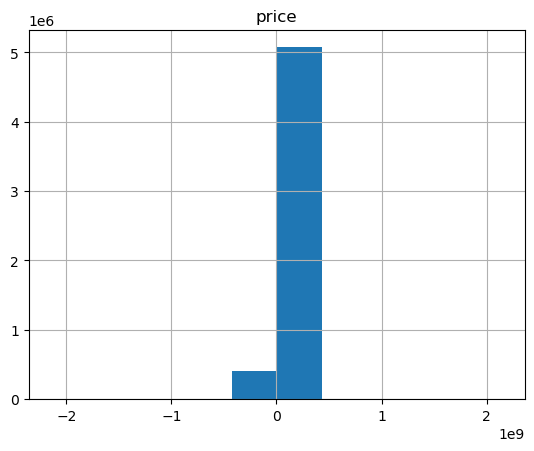

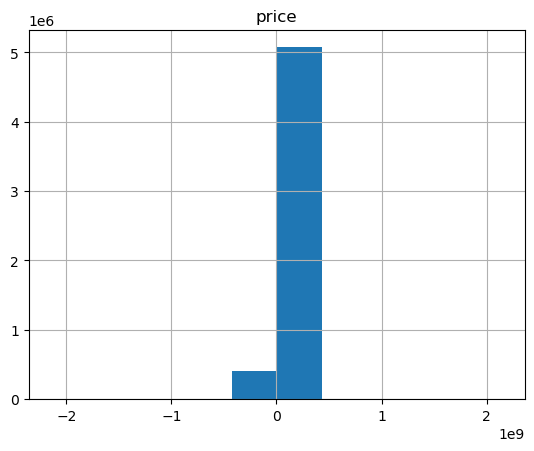

In [11]:
plt.close("all")
f_hist, axes_hist = plt.subplots(1)
c1.hist(ax=axes_hist, column=['price'])
f_hist

Как можно заметить пропущенных значений нет. Однако  начнем с того, что в столбце price(цена) имеются отрицательные значения. Посчитаем их.

In [12]:
print(df.filter(df.price<=100000).count()/df.count())
df = df.where(df.price>=100000)

0.0008088360684651432


Также стоит обратить внимание на контекст датасета. Когда цена указана меньше какой-то реальной(например 0 или 1), то скорее всего это намеренное желание продавца привлечь внимание к своему имуществу. Поэтому решено было удалить значения цены меньше 1000000. 

In [13]:
df = df[df.price>=100000]
print(df.count())

5472751


Обратим внимание на то, что есть строки, где площадь кухни больше площади квартиры в целом. Удалим их.

In [14]:
df = df.where(df.area>df.kitchen_area)

In [15]:
df.filter(df.area<df.kitchen_area).count()

0

In [16]:
df.filter(df.area>df.kitchen_area).show(truncate=False)  

+---------+---------+---------+------+-------------+-----+------+------+----+------------+-----------+
|price    |geo_lat  |geo_lon  |region|building_type|level|levels|rooms |area|kitchen_area|object_type|
+---------+---------+---------+------+-------------+-----+------+------+----+------------+-----------+
|6050000.0|59.80581 |30.37614 |2661  |1            |8    |10    |3     |82.6|10.8        |1          |
|8650000.0|55.683807|37.297405|81    |3            |5    |24    |2     |69.1|12.0        |1          |
|4000000.0|56.29525 |44.061638|2871  |1            |5    |9     |3     |66.0|10.0        |1          |
|1850000.0|44.99613 |39.074783|2843  |4            |12   |16    |2     |38.0|5.0         |11         |
|5450000.0|55.918766|37.984642|81    |3            |13   |14    |2     |60.0|10.0        |1          |
|3300000.0|55.908253|37.726448|81    |1            |4    |5     |1     |32.0|6.0         |1          |
|4704280.0|55.621098|37.431   |3     |2            |1    |25    |1     |3

Удалим дубликаты, если таковые имеются

In [17]:
df = df.distinct()

In [18]:
tempList = [] 
for col in df.columns:
        new_name = col.strip()
        new_name = "".join(new_name.split())
        new_name = new_name.replace('.','') # EDIT
        tempList.append(new_name) #Edit02
print(tempList) #Just for the sake of it #Edit03

df = df.toDF(*tempList) #Edit04

['price', 'geo_lat', 'geo_lon', 'region', 'building_type', 'level', 'levels', 'rooms', 'area', 'kitchen_area', 'object_type']


Далее посмотри на столбец комнаты. 

In [19]:
df.groupBy('rooms').count().show()

+-----+-------+
|rooms|  count|
+-----+-------+
|   -1| 174184|
|    1|1638241|
|    6|   2293|
|    3| 883820|
|    5|  18270|
|    9|    334|
|    4| 129025|
|    8|    345|
|    7|    776|
|   -2|    213|
|    2|1550332|
|   10|      1|
+-----+-------+



Как написано в описании датасета значение -1 в колонке rooms означает что данная квартира - студия. Однако про -2 ничего не сказано, поэтому скорее всего это ошибка. Удалить эти значения,а -1 заменим на 0.

In [20]:
df=df.where(df.rooms!="-2")

In [21]:
df = df.withColumn("rooms", when(df.rooms == "-1","0") \
      .otherwise(df.rooms))
df.show()

+---------+---------+---------+------+-------------+-----+------+-----+-----+------------+-----------+
|    price|  geo_lat|  geo_lon|region|building_type|level|levels|rooms| area|kitchen_area|object_type|
+---------+---------+---------+------+-------------+-----+------+-----+-----+------------+-----------+
|2500000.0|43.634693|39.727165|  2843|            2|    2|     8|    0| 25.0|         5.0|          1|
|1500000.0|  54.8887|38.605206|    81|            3|    2|     2|    2| 40.0|         6.0|          1|
|4235680.0|55.696846|37.907326|    81|            1|   25|    25|    1| 36.8|         9.3|         11|
|3690000.0| 55.57747|38.205257|    81|            2|    6|    10|    1| 43.0|        11.0|          1|
|2310000.0|55.016808| 83.00891|  9654|            1|    1|    10|    3|59.02|         8.5|          1|
|2300000.0| 54.94714|82.958595|  9654|            1|    4|    10|    2|63.13|       12.05|         11|
|2460000.0|55.053036| 82.89764|  9654|            3|    5|    19|    1| 4

In [22]:
print(df.count())

4397621


Далее обратим внимание на то, что максимальное значение региона - 6188, однако в России  на момент составления датасета в РФ насчитывалось 84 субъекта.

In [23]:
df.groupBy('region').count().toPandas()

,region,count
0,6937,4635
1,5178,723
2,8640,1584
3,81,473777
4,2484,5309
...,...,...
79,2661,434322
80,2900,56378
81,4982,31723
82,2528,8174


In [24]:
df.select('region').distinct().collect()

[Row(region=6937),
 Row(region=5178),
 Row(region=8640),
 Row(region=81),
 Row(region=2484),
 Row(region=8090),
 Row(region=2871),
 Row(region=4695),
 Row(region=5993),
 Row(region=4240),
 Row(region=7873),
 Row(region=13098),
 Row(region=5282),
 Row(region=3991),
 Row(region=7896),
 Row(region=9654),
 Row(region=1491),
 Row(region=3446),
 Row(region=6543),
 Row(region=7793),
 Row(region=3),
 Row(region=5520),
 Row(region=61888),
 Row(region=2880),
 Row(region=6171),
 Row(region=2885),
 Row(region=10582),
 Row(region=1010),
 Row(region=2072),
 Row(region=5736),
 Row(region=13919),
 Row(region=14880),
 Row(region=8894),
 Row(region=4374),
 Row(region=4249),
 Row(region=5789),
 Row(region=8509),
 Row(region=11171),
 Row(region=1901),
 Row(region=4007),
 Row(region=10201),
 Row(region=11991),
 Row(region=6309),
 Row(region=2814),
 Row(region=9648),
 Row(region=821),
 Row(region=69),
 Row(region=4086),
 Row(region=2328),
 Row(region=11416),
 Row(region=2722),
 Row(region=5794),
 Row(region

Действительно, всего 84 строки = 84 региона. На данном этапе оставим этот столбец как есть.

## Нахождение региона по координатам ##

In [25]:
df = df.withColumn("geo_lat", df["geo_lat"].cast(FloatType()))
df = df.withColumn("geo_lon", df["geo_lon"].cast(FloatType()))

Пользуясь простейшим способом поиска названия регионов по координатам ('geo_lat', 'geo_lon'), я выписала все значения в словарь 'region_name' в соответствии с номером региона ('region') в датасете.

In [26]:
region_name = {                    
    '2661': 'Санкт-Петербург',
    '3446': 'Ленинградская область', 
    '3': 'Москва',
    '81': 'Московская область',
    '2843': 'Краснодарский край',
    '2871': 'Нижегородская область',
    '3230': 'Ростовская область',
    '3106': 'Самарская область',
    '2922': 'Республика Татарстан',
    '2900': 'Ставропольский край',
    '2722': 'Республика Башкортостан',
    '6171': 'Свердловская область', 
    '4417': 'Республика Коми', 
    '5282': 'Челябинская область', 
    '5368': 'Иркутская область', 
    '5520': 'Пермский край', 
    '6817': 'Алтайский край',
    '9579': 'Республика Бурятия',
    '2604': 'Ярославская область',
    '1010': 'Удмуртская Республика',
    '7793': 'Псковская область',
    '13919': 'Республика Северная Осетия — Алания',
    '2860': 'Кемеровская область',
    '3019': 'Чувашская Республика',
    '4982': 'Республика Марий Эл',
    '9648': 'Кабардино-Балкарская Республика',
    '5241': 'Республика Мордовия',
    '3870': 'Красноярский край',
    '3991': 'Тюменская область',
    '2359': 'Республика Хакасия',
    '9654': 'Новосибирская область',
    '2072': 'Воронежская область',
    '8090': 'Республика Карелия',
    '4007': 'Республика Дагестан',
    '11171': 'Республика Саха (Якутия)',
    '10160': 'Забайкальский край',
    '7873' : 'Республика Крым',
    '6937': 'Республика Крым',
    '2594': 'Кировская область',
    '8509': 'Республика Калмыкия',
    '11416': 'Республика Адыгея',
    '11991': 'Карачаево-Черкесская Республика',
    '5178': 'Республика Тыва',
    '13913': 'Республика Ингушетия',
    '6309': 'Республика Алтай',
    '5952': 'Белгородская область',
    '6543': 'Архангельская область',
    '2880': 'Тверская область',
    '5993': 'Пензенская область',
    '2484': 'Ханты-Мансийский автономный округ',
    '4240': 'Липецкая область',
    '5789': 'Владимирская область',
    '14880': 'Ямало-Ненецкий автономный округ',
    '1491': 'Рязанская область',
    '2885': 'Чеченская Республика',
    '5794': 'Смоленская область',
    '2528': 'Саратовская область',
    '4374': 'Вологодская область',
    '4695': 'Волгоградская область',
    '2328': 'Калужская область',
    '5143': 'Тульская область',
    '2806': 'Тамбовская область',
    '14368': 'Мурманская область',
    '5736': 'Новгородская область',
    '7121': 'Курская область',
    '4086': 'Хабаровский край',
    '821': 'Брянская область',
    '10582': 'Астраханская область',
    '7896': 'Калининградская область',
    '8640': 'Омская область',
    '5703': 'Курганская область',
    '10201': 'Томская область',
    '4249': 'Ульяновская область',
    '3153': 'Оренбургская область',
    '4189': 'Костромская область',
    '2814': 'Орловская область',
    '13098': 'Камчатский край',
    '8894': 'Ивановская область',
    '7929': 'Амурская область',
    '16705': 'Магаданская область',
    '69': 'Еврейская автономная область',
    '4963': 'Приморский край',
    '1901': 'Сахалинская область',
    '61888': 'Ненецкий автономный округ'
}

In [27]:
from itertools import chain
from pyspark.sql.functions import create_map, lit

mapping_expr = create_map([lit(x) for x in chain(*region_name.items())])

df = df.withColumn('region_name', mapping_expr[df['region']])

df.show(truncate=False)

+---------+---------+---------+------+-------------+-----+------+-----+-----+------------+-----------+---------------------+
|price    |geo_lat  |geo_lon  |region|building_type|level|levels|rooms|area |kitchen_area|object_type|region_name          |
+---------+---------+---------+------+-------------+-----+------+-----+-----+------------+-----------+---------------------+
|2500000.0|43.634693|39.727165|2843  |2            |2    |8     |0    |25.0 |5.0         |1          |Краснодарский край   |
|1500000.0|54.8887  |38.605206|81    |3            |2    |2     |2    |40.0 |6.0         |1          |Московская область   |
|4235680.0|55.696846|37.907326|81    |1            |25   |25    |1    |36.8 |9.3         |11         |Московская область   |
|3690000.0|55.57747 |38.205257|81    |2            |6    |10    |1    |43.0 |11.0        |1          |Московская область   |
|2310000.0|55.016808|83.00891 |9654  |1            |1    |10    |3    |59.02|8.5         |1          |Новосибирская область|


## Поиск и удаление выбросов ##

Для поиска и удаления выбросов воспользуемся методом IQR (межквартильный диапазон). 

In [28]:
def remove_outliers(df, column):
    q1, q3 = df.approxQuantile(column, [0.25, 0.75], 0.05)
    iqr = q3 - q1
    low = q1 - 1.5 * iqr
    high = q3 + 1.5 * iqr
    return df.where((df[column] >= low) & (df[column] <= high))

In [29]:
print(df.count())

4397621


До удаления выбросов 4397621 значений

In [30]:
c1 = df.toPandas()

<AxesSubplot: >

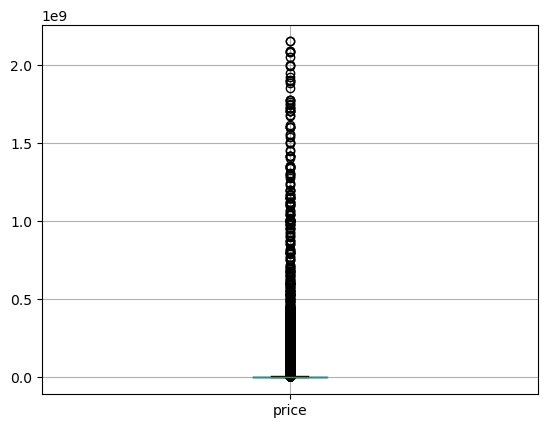

In [31]:
plt.close("all")
f_price, axes_price = plt.subplots(1)
c1.boxplot(ax=axes_price, column=['price'], figsize=(10,  10))

<AxesSubplot: >

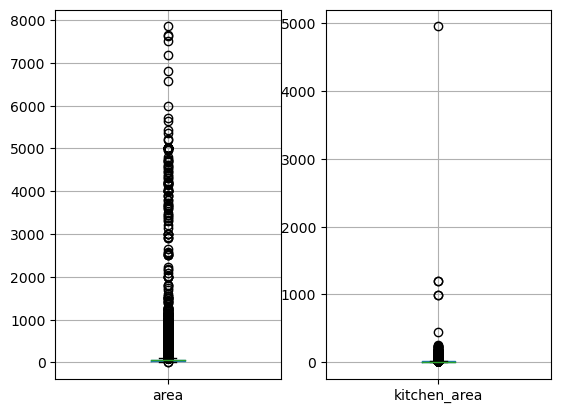

In [32]:
plt.close("all")
f_other, axes_other = plt.subplots(1,2)
c1.boxplot(ax=axes_other[0], column=['area'], figsize=(10,  10))
c1.boxplot(ax=axes_other[1], column=['kitchen_area'], figsize=(10,  10))

In [33]:
df = remove_outliers(df, 'price')
df = remove_outliers(df, 'area')
df = remove_outliers(df, 'kitchen_area')

In [34]:
c1 = df.toPandas()

<AxesSubplot: >

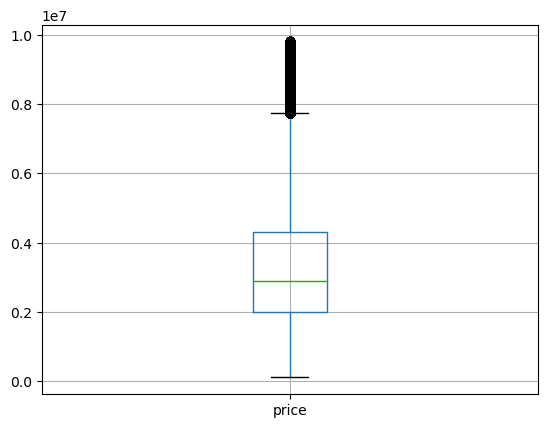

In [35]:
plt.close("all")
f_price, axes_price = plt.subplots(1)
c1.boxplot(ax=axes_price, column=['price'], figsize=(10,  10))

<AxesSubplot: >

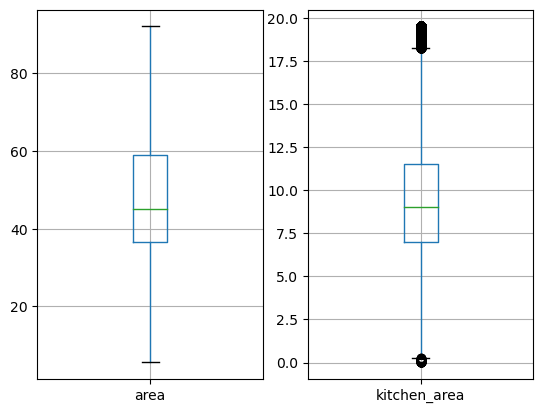

In [36]:
plt.close("all")
f_other, axes_other = plt.subplots(1,2)
c1.boxplot(ax=axes_other[0], column=['area'], figsize=(10,  10))
c1.boxplot(ax=axes_other[1], column=['kitchen_area'], figsize=(10,  10))

In [37]:
print(df.filter(df.kitchen_area<=1.75).count()/df.count())

0.0024934231829889545


In [38]:
df = df.where(df.kitchen_area>1.75)

In [39]:
df.describe().show()

+-------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-------------------+
|summary|             price|          geo_lat|           geo_lon|            region|     building_type|            level|            levels|             rooms|              area|     kitchen_area|       object_type|        region_name|
+-------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+------------------+------------------+-----------------+------------------+-------------------+
|  count|           3770519|          3770519|           3770519|           3770519|           3770519|          3770519|           3770519|           3770519|           3770519|          3770519|           3770519|            3770519|
|   mean|3387280.3516600765|53.84268175420054| 50.231876

Исходя из полученных данных из статистики цена квартиру находится в диапазоне от 100000 до 9821940 рублей, а среднее значение 3385251, что в целом больше похоже на правду. Среднеквадратическое отклонение небольше,что говорит о том, что значения в множестве сгруппированы вокруг среднего значения.

## Корреляция ##

In [40]:
df = df.withColumn("rooms", df["rooms"].cast(IntegerType()))

In [41]:
cols = "price","geo_lat","geo_lon","region","level","levels","area","kitchen_area","object_type","rooms","building_type"
va = VectorAssembler(inputCols=cols, outputCol="num")
corr_df = va.transform(df).select('num')

corr = Correlation.corr(corr_df, 'num')

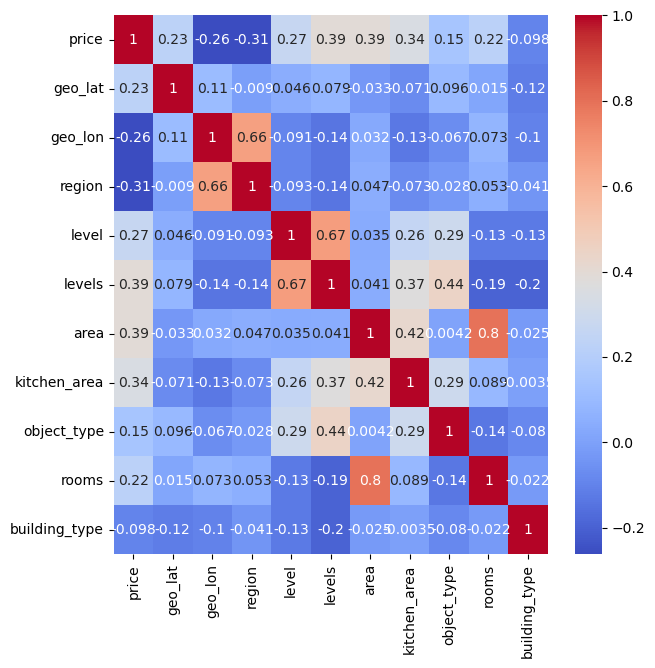

In [42]:
plt.close("all")
f2, axes2 = plt.subplots(1, figsize=(7,7))
corr_mat = pd.DataFrame(corr.collect()[0][0].toArray(), columns=cols, index=cols)
_ = sns.heatmap(ax=axes2, data=corr_mat, robust=True, annot=True, cmap= 'coolwarm')


Исходя из полученной матрицы, мы можем наблюдать, что цена зависит от этажности дома, площади квартиры и кухни, от региона, а также от количества комнат сильнее всего.
В остальных случая наблюдается небольшая или даже слабая корреляция. 

## Визуализация данных ##

### Гистограммы ###

array([<AxesSubplot: title={'center': 'levels'}>], dtype=object)

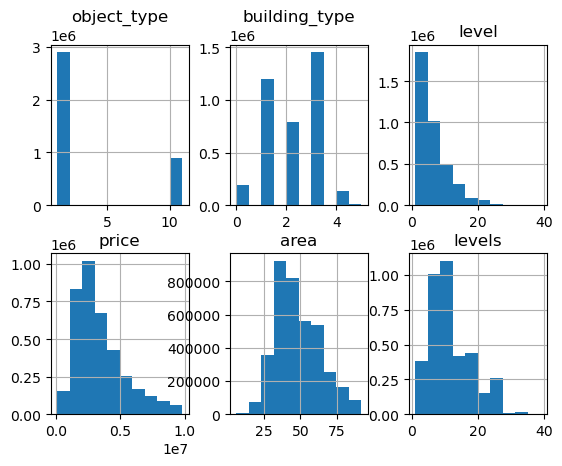

In [50]:
plt.close("all")
f_hist, axes_hist = plt.subplots(2,3)
c1.hist(ax=axes_hist[0,0], column=['object_type'])
c1.hist(ax=axes_hist[0,1], column=['building_type'])
c1.hist(ax=axes_hist[0,2], column=['level'])
c1.hist(ax=axes_hist[1,0], column=['price'])
c1.hist(ax=axes_hist[1,1], column=['area'])
c1.hist(ax=axes_hist[1,2], column=['levels'])

In [44]:
regions = df.select('region', 'region_name').toPandas()

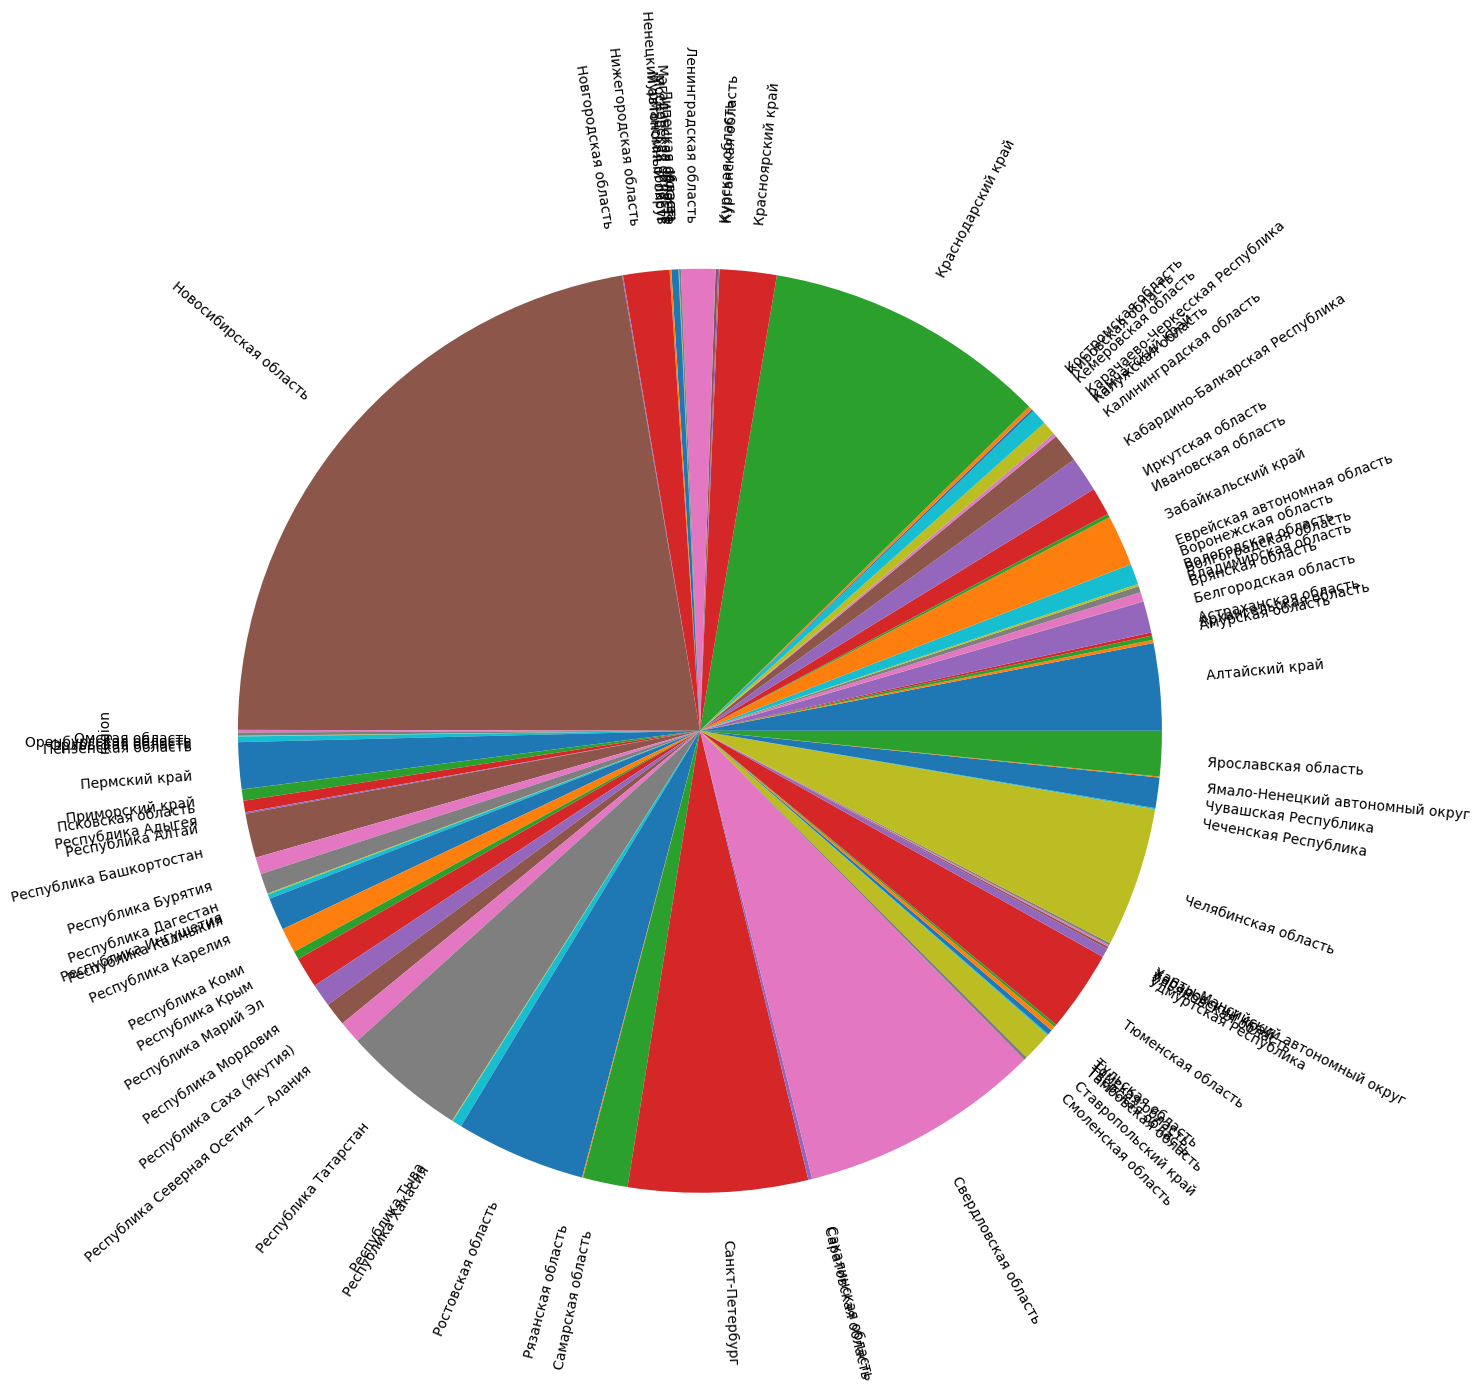

In [45]:
plt.close("all")
p = regions.groupby(['region_name']).sum().plot(kind='pie', y='region', rotatelabels = 270, figsize=(15, 15), legend=None)


In [46]:
import geopandas as gpd

In [47]:
plot_df = df
count = plot_df.count()

russia = gpd.read_file('data/admin_level_6.shx')
ax = russia.plot(color="lightgrey", figsize=(300, 275))

ax = df.select('geo_lat', 'geo_lon').toPandas().plot.scatter(
    x='geo_lon', y='geo_lat', ax=ax, label = 'apart',
    marker='.', s=100)

ax.legend(loc='lower left');

## Сохранение датасета ##

In [48]:
df=df.drop('region_name')

In [49]:
df.toPandas().to_csv('data/clean_data.csv', index=False)